In [3]:
# Celdas para leer directamente un archivo .arff en Python

# 1. Importar librer√≠as necesarias
import pandas as pd
from scipy.io import arff
# Removed incorrect import of load_arff
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import MinMaxScaler

### Lectura y carga del conjunto de datos

Se utiliza la librer√≠a `scipy.io.arff` para leer el archivo `.arff`, un formato com√∫n en herramientas como WEKA. Posteriormente, se convierte en un `DataFrame` de pandas y se decodifican las columnas tipo byte a texto. Esta transformaci√≥n permite trabajar c√≥modamente con los datos en Python.


### Exploraci√≥n inicial del dataset

A continuaci√≥n se muestra informaci√≥n general del conjunto de datos, incluyendo el n√∫mero de instancias, el tipo de datos por columna, un resumen estad√≠stico b√°sico y la moda de cada atributo. Esto permite detectar valores at√≠picos, errores de tipo y posibles problemas de calidad en los datos.


In [4]:
# 2. Definir la ruta al archivo .arff
darff_path = Path('Sapfile1.arff')  # <-- Ajusta si est√° en otra carpeta

# 3. Leer el .arff usando scipy
#    Devuelve una tupla (data, meta)
data_scipy, meta_scipy = arff.loadarff(str(darff_path))
# Convertir a DataFrame
df_scipy = pd.DataFrame(data_scipy)
# Decodificar columnas byte a texto si es necesario
for col in df_scipy.select_dtypes([object]):
    df_scipy[col] = df_scipy[col].str.decode('utf-8')
print("Primeras filas con scipy:")
print(df_scipy.head())




Primeras filas con scipy:
  ge   cst   tnp   twp iap   esp arr         ms ls    as  ...  fq  mq  \
0  F     G  Good  Good  Vg  Good   Y  Unmarried  V  Paid  ...  Um  10   
1  M   OBC    Vg    Vg  Vg    Vg   N  Unmarried  V  Paid  ...  Um  Il   
2  F   OBC  Good  Good  Vg  Good   N  Unmarried  V  Paid  ...  12  10   
3  M  MOBC  Pass  Good  Vg  Good   N  Unmarried  V  Paid  ...  12  Um   
4  M     G  Good  Good  Vg    Vg   N  Unmarried  V  Paid  ...  10  12   

         fo         mo       nf       sh       ss   me       tt      atd  
0    Farmer  Housewife    Large     Poor     Govt  Asm    Small     Good  
1   Service    Service    Small     Poor     Govt  Asm  Average  Average  
2   Service  Housewife  Average  Average     Govt  Asm    Large     Good  
3  Business   Business    Large     Poor     Govt  Asm  Average  Average  
4   Service  Housewife    Large     Poor  Private  Asm    Small     Good  

[5 rows x 22 columns]


### Verificaci√≥n de datos faltantes o especiales

Se comprueba si existen valores nulos (`NaN`) o valores especiales como `'?'`, que podr√≠an haber sido utilizados para representar datos desconocidos. En este caso, no se detectaron datos faltantes, lo cual facilita el an√°lisis posterior.


In [5]:
# Verificar cantidad de filas (instancias)
print("N√∫mero de instancias:", df_scipy.shape[0])

# Verificar valores nulos reales (NaN)
print("\nValores nulos por columna:")
print(df_scipy.isnull().sum())

# Buscar valores '?' como posibles datos faltantes
print("\nValores '?' por columna:")
for col in df_scipy.columns:
    if df_scipy[col].dtype == object:
        print(f"{col}: {(df_scipy[col] == '?').sum()}")


N√∫mero de instancias: 131

Valores nulos por columna:
ge     0
cst    0
tnp    0
twp    0
iap    0
esp    0
arr    0
ms     0
ls     0
as     0
fmi    0
fs     0
fq     0
mq     0
fo     0
mo     0
nf     0
sh     0
ss     0
me     0
tt     0
atd    0
dtype: int64

Valores '?' por columna:
ge: 0
cst: 0
tnp: 0
twp: 0
iap: 0
esp: 0
arr: 0
ms: 0
ls: 0
as: 0
fmi: 0
fs: 0
fq: 0
mq: 0
fo: 0
mo: 0
nf: 0
sh: 0
ss: 0
me: 0
tt: 0
atd: 0


In [6]:
print("Tipos de datos del DataFrame:")
print(df_scipy.dtypes)


Tipos de datos del DataFrame:
ge     object
cst    object
tnp    object
twp    object
iap    object
esp    object
arr    object
ms     object
ls     object
as     object
fmi    object
fs     object
fq     object
mq     object
fo     object
mo     object
nf     object
sh     object
ss     object
me     object
tt     object
atd    object
dtype: object


### An√°lisis de la variable objetivo (`atd`)

Se identific√≥ la variable `atd` como la variable objetivo del problema, ya que representa el rendimiento acad√©mico final del estudiante. Se analiza su distribuci√≥n de clases para verificar si se trata de un problema de clasificaci√≥n balanceado o desbalanceado.


In [7]:
# An√°lisis de la variable objetivo
print("Valores √∫nicos en 'atd':")
print(df_scipy['atd'].value_counts())


Valores √∫nicos en 'atd':
atd
Good       56
Average    47
Poor       28
Name: count, dtype: int64


### Eliminaci√≥n de variables constantes

Se identific√≥ que la variable `ms` (estado civil) contiene un √∫nico valor en todas las instancias. Las variables constantes no aportan informaci√≥n √∫til al modelo y pueden introducir ruido, por lo que se ha eliminado del conjunto de datos.


In [8]:
# Eliminar columna constante
df_scipy.drop(columns=['ms'], inplace=True)


### Codificaci√≥n de atributos categ√≥ricos

Como todos los atributos son categ√≥ricos, se codifican con `LabelEncoder` para transformarlos en valores num√©ricos enteros. Esto es necesario ya que muchos algoritmos de aprendizaje autom√°tico no pueden trabajar directamente con texto. Se guarda un codificador por cada atributo para poder revertir las transformaciones o interpretar los resultados m√°s adelante.


In [9]:
# Llevar la columna 'atd' al final
target = 'atd'
df_scipy = df_scipy[[col for col in df_scipy.columns if col != target] + [target]]

# Crear copia para no tocar el original directamente
df_encoded = df_scipy.copy()

# Aplicar LabelEncoder a todas las columnas (incluyendo el target)
label_encoders = {}
for col in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # guardar por si luego se necesita invertir

# Mostrar las primeras filas codificadas
df_encoded.head()

ge  cst  tnp  twp  iap  esp  arr  ls  as  fmi  ...  fq  mq  fo  mo  nf  sh  \
0   0    0    1    1    3    1    1   1   1    3  ...   5   0   1   1   1   2   
1   1    2    3    3    3    3    0   1   1    2  ...   5   3   4   4   2   2   
2   0    2    1    1    3    1    0   1   1    0  ...   1   0   4   1   0   0   
3   1    1    2    1    3    1    0   1   1    3  ...   1   5   0   0   1   2   
4   1    0    1    1    3    3    0   1   1    0  ...   0   1   4   1   1   2   

   ss  me  tt  atd  
0   0   0   2    1  
1   0   0   0    0  
2   0   0   1    1  
3   0   0   0    0  
4   1   0   2    1  

[5 rows x 21 columns]

In [10]:
df_encoded.describe(include='all')

ge         cst         tnp         twp         iap         esp  \
count  131.000000  131.000000  131.000000  131.000000  131.000000  131.000000   
mean     0.549618    1.618321    1.702290    1.763359    1.954198    1.786260   
std      0.499442    1.378171    0.966315    0.967408    1.065996    0.968803   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    1.000000    1.000000    1.000000    1.000000   
50%      1.000000    2.000000    1.000000    1.000000    2.000000    2.000000   
75%      1.000000    2.000000    3.000000    3.000000    3.000000    3.000000   
max      1.000000    4.000000    3.000000    3.000000    3.000000    3.000000   

              arr          ls          as         fmi  ...          fq  \
count  131.000000  131.000000  131.000000  131.000000  ...  131.000000   
mean     0.404580    0.702290    0.580153    2.045802  ...    2.641221   
std      0.492695    0.459007    0.495428    1.270146  ...    1.889521   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%      0.000000    0.000000    0.000000    1.000000  ...    1.000000   
50%      0.000000    1.000000    1.000000    3.000000  ...    3.000000   
75%      1.000000    1.000000    1.000000    3.000000  ...    5.000000   
max      1.000000    1.000000    1.000000    4.000000  ...    5.000000   

               mq          fo          mo          nf         sh          ss  \
count  131.000000  131.000000  131.000000  131.000000  131.00000  131.000000   
mean     2.931298    1.877863    1.297710    0.900763    0.89313    0.305344   
std      1.981417    1.559205    0.891797    0.742708    0.88797    0.462321   
min      0.000000    0.000000    0.000000    0.000000    0.00000    0.000000   
25%      1.000000    0.000000    1.000000    0.000000    0.00000    0.000000   
50%      3.000000    2.000000    1.000000    1.000000    1.00000    0.000000   
75%      5.000000    4.000000    1.000000    1.000000    2.00000    1.000000   
max      5.000000    4.000000    4.000000    2.000000    2.00000    1.000000   

               me          tt         atd  
count  131.000000  131.000000  131.000000  
mean     1.122137    1.267176    0.854962  
std      1.067152    0.926735    0.745470  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      2.000000    2.000000    1.000000  
75%      2.000000    2.000000    1.000000  
max      3.000000    2.000000    2.000000  

[8 rows x 21 columns]

In [11]:
df_encoded.mode().T  # Moda por columna


0
ge   1
cst  2
tnp  1
twp  1
iap  3
esp  1
arr  0
ls   1
as   1
fmi  3
fs   2
fq   5
mq   5
fo   4
mo   1
nf   1
sh   0
ss   0
me   2
tt   2
atd  1

### An√°lisis de correlaci√≥n entre atributos

Se calcula la matriz de correlaciones de Pearson entre todos los atributos codificados. Esta matriz permite detectar relaciones lineales entre variables, redundancias y dependencias. Los valores han sido redondeados a dos decimales para facilitar su interpretaci√≥n visual.


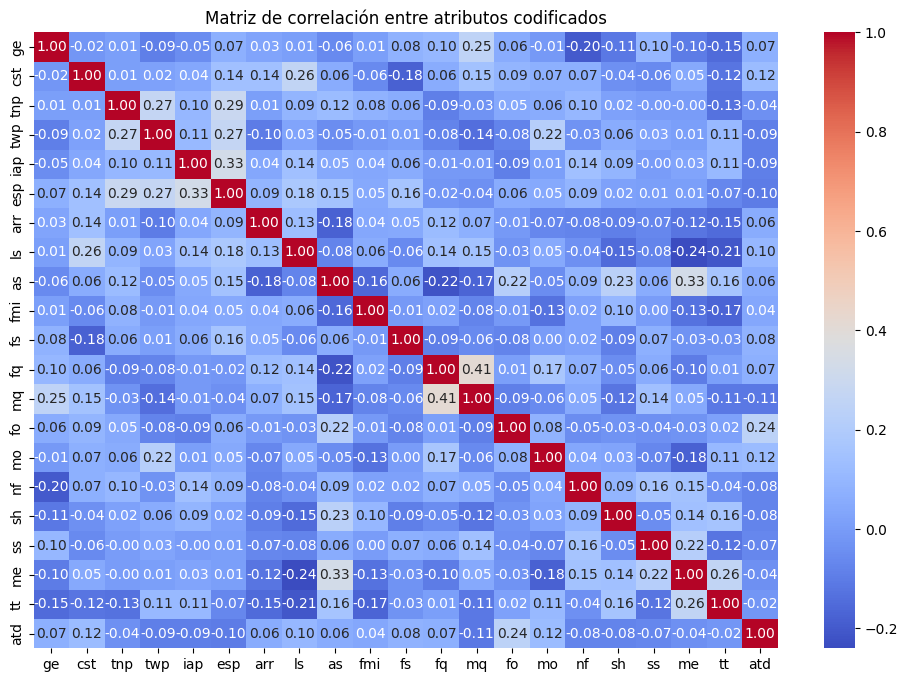

In [12]:
# Crear matriz de correlaci√≥n redondeada a 2 decimales
corr_matrix = df_encoded.corr().round(2)

# Graficar
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de correlaci√≥n entre atributos codificados")
plt.show()

In [13]:
for col in df_encoded.columns:
    print(f"{col}:\n{df_encoded[col].value_counts(normalize=True)}\n")


ge:
ge
1    0.549618
0    0.450382
Name: proportion, dtype: float64

cst:
cst
2    0.435115
0    0.335878
4    0.152672
1    0.045802
3    0.030534
Name: proportion, dtype: float64

tnp:
tnp
1    0.450382
3    0.290076
2    0.190840
0    0.068702
Name: proportion, dtype: float64

twp:
twp
1    0.496183
3    0.335878
2    0.129771
0    0.038168
Name: proportion, dtype: float64

iap:
iap
3    0.480916
1    0.404580
0    0.061069
2    0.053435
Name: proportion, dtype: float64

esp:
esp
1    0.412214
3    0.320611
2    0.206107
0    0.061069
Name: proportion, dtype: float64

arr:
arr
0    0.59542
1    0.40458
Name: proportion, dtype: float64

ls:
ls
1    0.70229
0    0.29771
Name: proportion, dtype: float64

as:
as
1    0.580153
0    0.419847
Name: proportion, dtype: float64

fmi:
fmi
3    0.480916
0    0.206107
2    0.152672
1    0.114504
4    0.045802
Name: proportion, dtype: float64

fs:
fs
2    0.679389
0    0.305344
1    0.015267
Name: proportion, dtype: float64

fq:
fq
5    0.305344


### Exploraci√≥n visual de la variable objetivo

Se representa gr√°ficamente la distribuci√≥n de clases de la variable `atd` mediante un gr√°fico de barras. Esto permite identificar desequilibrios y entender mejor la composici√≥n del conjunto de datos.


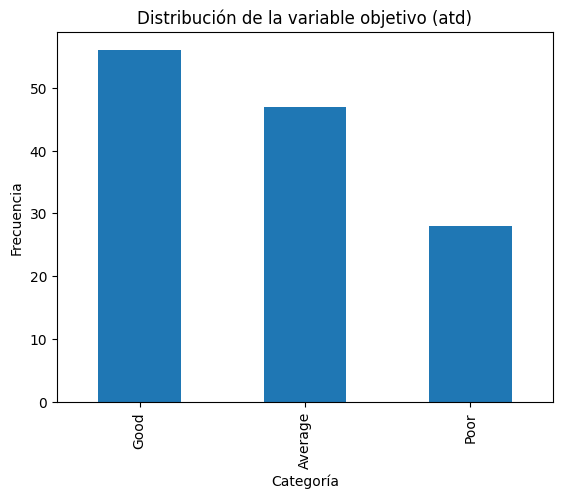

In [14]:
df_scipy['atd'].value_counts().plot(kind='bar', title='Distribuci√≥n de la variable objetivo (atd)')
plt.xlabel('Categor√≠a')
plt.ylabel('Frecuencia')
plt.show()


### Evaluaci√≥n de importancia de atributos

Se calcula la relevancia de cada atributo en relaci√≥n con la variable objetivo utilizando dos m√©todos:

- **Informaci√≥n mutua**: mide cu√°nta informaci√≥n comparte un atributo con el target, √∫til en contextos no lineales y categ√≥ricos.
- **Chi-cuadrado**: eval√∫a la dependencia estad√≠stica entre variables categ√≥ricas mediante tablas de contingencia. Se presentan tambi√©n los p-valores asociados para interpretar la significancia estad√≠stica.

Ambas m√©tricas permiten identificar atributos informativos frente a atributos irrelevantes.


In [15]:
X = df_encoded.drop('atd', axis=1)
y = df_encoded['atd']

# --- Mutual Information ---
mi_scores = mutual_info_classif(X, y, discrete_features=True)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("Informaci√≥n mutua (mutual_info_classif):")
print(mi_series)

Informaci√≥n mutua (mutual_info_classif):
esp    0.130715
tnp    0.129410
twp    0.111031
mq     0.084945
nf     0.078623
fmi    0.070188
as     0.045595
iap    0.044997
fo     0.042658
fq     0.039838
ge     0.036499
me     0.030491
cst    0.028251
mo     0.026988
sh     0.022911
ss     0.013713
ls     0.010637
tt     0.007119
fs     0.006786
arr    0.005990
dtype: float64


In [16]:
# --- Chi-cuadrado ---
# Necesitamos valores positivos para usar chi2 ‚Üí escalar X si fuera necesario
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

chi2_scores, p_values = chi2(X_scaled, y)
chi2_series = pd.Series(chi2_scores, index=X.columns).sort_values(ascending=False)

print("\nChi-cuadrado (chi2):")
print(chi2_series)


Chi-cuadrado (chi2):
as     4.873010
ge     4.193384
nf     3.380179
fo     2.501528
ss     2.372179
tnp    1.662317
sh     1.079467
arr    0.941618
ls     0.835127
twp    0.703342
mq     0.682177
cst    0.539979
fq     0.444630
esp    0.426904
me     0.351965
mo     0.302927
fs     0.260897
iap    0.255257
fmi    0.226235
tt     0.154381
dtype: float64


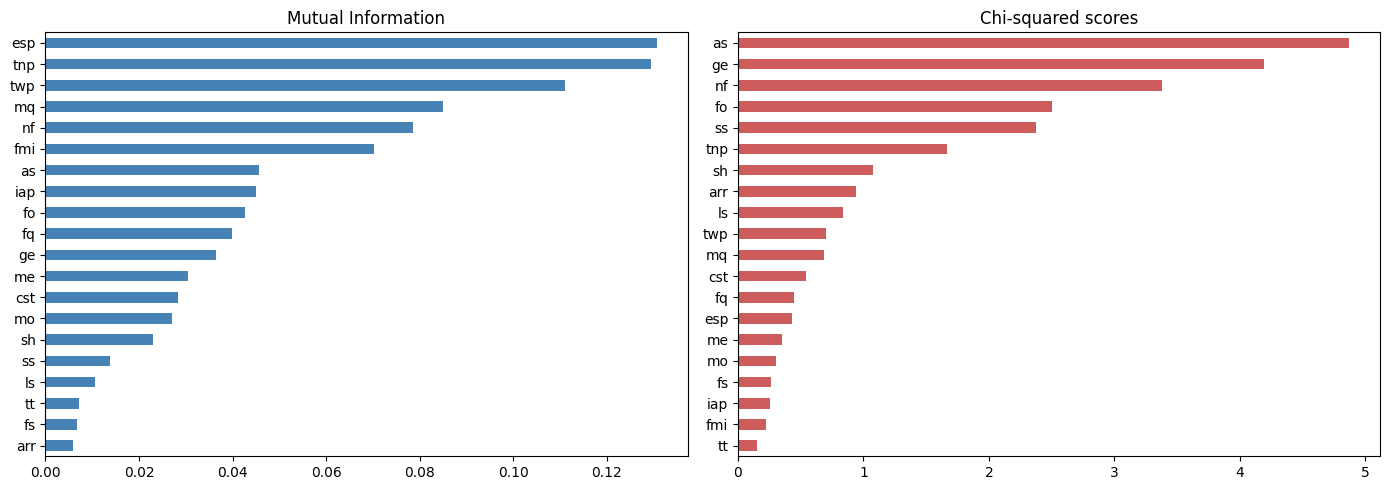

In [17]:
# Comparar visualmente
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
mi_series.plot(kind='barh', title='Mutual Information', color='steelblue')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
chi2_series.plot(kind='barh', title='Chi-squared scores', color='indianred')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [18]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Asegurarse de que X no tenga valores negativos para chi¬≤
X = df_encoded.drop(columns=['atd'])
y = df_encoded['atd']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Chi-cuadrado
chi2_scores, p_values = chi2(X_scaled, y)

# Crear DataFrame ordenado
chi2_df = pd.DataFrame({
    'Chi2 Score': chi2_scores,
    'p-value': p_values
}, index=X.columns).sort_values(by='p-value')

print(chi2_df)


     Chi2 Score   p-value
as     4.873010  0.087466
ge     4.193384  0.122862
nf     3.380179  0.184503
fo     2.501528  0.286286
ss     2.372179  0.305413
tnp    1.662317  0.435544
sh     1.079467  0.582903
arr    0.941618  0.624497
ls     0.835127  0.658650
twp    0.703342  0.703512
mq     0.682177  0.710996
cst    0.539979  0.763387
fq     0.444630  0.800663
esp    0.426904  0.807791
me     0.351965  0.838633
mo     0.302927  0.859449
fs     0.260897  0.877702
iap    0.255257  0.880180
fmi    0.226235  0.893046
tt     0.154381  0.925713


### Justificaci√≥n del uso limitado del p-valor en este dataset

Aunque el test chi-cuadrado y sus p-valores son √∫tiles para evaluar la dependencia estad√≠stica entre variables categ√≥ricas y la variable objetivo, en este caso concreto su aplicabilidad presenta limitaciones importantes:

- **Tama√±o de muestra reducido**: el dataset contiene √∫nicamente 131 instancias, lo que reduce la capacidad del test para detectar relaciones sutiles. Con muestras peque√±as, incluso relaciones reales pueden no alcanzar significaci√≥n estad√≠stica.
  
- **Codificaci√≥n de variables categ√≥ricas**: todas las variables han sido codificadas con `LabelEncoder`, lo que convierte sus valores en enteros. Esta transformaci√≥n no representa una escala ordinal real, y puede distorsionar los supuestos del test chi-cuadrado.

- **Hip√≥tesis nula conservadora**: el test solo rechaza la hip√≥tesis de independencia si existe evidencia estad√≠stica fuerte. Sin embargo, el hecho de no rechazarla no implica ausencia de relaci√≥n, especialmente en contextos con baja potencia estad√≠stica.

Por todo ello, en lugar de usar el p-valor como √∫nico criterio de selecci√≥n de atributos, se han combinado **medidas m√°s robustas y espec√≠ficas para aprendizaje autom√°tico**, como:

- **Informaci√≥n mutua (mutual information)**: mide cu√°nta informaci√≥n aporta cada atributo para predecir la clase.
- **Correlaci√≥n de Pearson** entre variables codificadas: permite explorar redundancia o independencia entre atributos.

Este enfoque permite una selecci√≥n m√°s confiable de variables relevantes para el modelado, priorizando tanto la precisi√≥n como la interpretabilidad.


### Eliminaci√≥n de atributos irrelevantes

Tras el an√°lisis combinado de correlaciones, informaci√≥n mutua e independencia estad√≠stica (chi-cuadrado con p-valor), se identificaron varios atributos con **muy baja capacidad predictiva** respecto a la variable objetivo `atd`. En particular, las variables `arr`, `tt`, `fs` y `ls` presentan simult√°neamente:

- **Correlaciones cercanas a cero** con la variable objetivo, indicando ausencia de relaci√≥n lineal tras la codificaci√≥n.
- **Valores muy bajos de informaci√≥n mutua**, lo que sugiere que aportan muy poca informaci√≥n √∫til para predecir `atd`.
- **P-valores elevados en el test chi-cuadrado** (superiores a 0.6), lo que refuerza la idea de independencia estad√≠stica entre estos atributos y el resultado acad√©mico.

Por tanto, se han eliminado estas columnas del conjunto de datos con el objetivo de:

- **Reducir la complejidad** del modelo
- **Mejorar la interpretabilidad**
- **Evitar introducir ruido** o variables redundantes en el proceso de entrenamiento

Esta decisi√≥n est√° respaldada tanto por criterios estad√≠sticos como por buenas pr√°cticas en el dise√±o de modelos predictivos en aprendizaje autom√°tico.


In [19]:
df_encoded.drop(columns=['arr', 'tt', 'fs', 'ls'], inplace=True)


# Fase de modelo Predictivo --Richard


### Modelado Predictivo

En esta secci√≥n se procede al entrenamiento y validaci√≥n de varios modelos predictivos con el objetivo de predecir la variable objetivo `atd`. La evaluaci√≥n se har√° tanto desde el punto de vista cuantitativo (precisi√≥n, matriz de confusi√≥n) como cualitativo (interpretabilidad, coste de aplicaci√≥n).

Los modelos seleccionados inicialmente son:
- √Årbol de Decisi√≥n (Decision Tree)
- Regresi√≥n Log√≠stica (Logistic Regression)
- k-Vecinos m√°s Cercanos (k-Nearest Neighbors)
- SVM (Support Vector Machine)
- Red Neuronal (MLP - Multi-Layer Perceptron)

Estos modelos ofrecen un equilibrio entre simplicidad e interpretabilidad, permitiendo establecer una l√≠nea base para comparar con t√©cnicas m√°s complejas si fuese necesario.



Modelo: √Årbol de Decisi√≥n
Accuracy: 0.5925925925925926
Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.50      0.30      0.38        10
           1       0.62      0.80      0.70        10
           2       0.62      0.71      0.67         7

    accuracy                           0.59        27
   macro avg       0.58      0.60      0.58        27
weighted avg       0.58      0.59      0.57        27



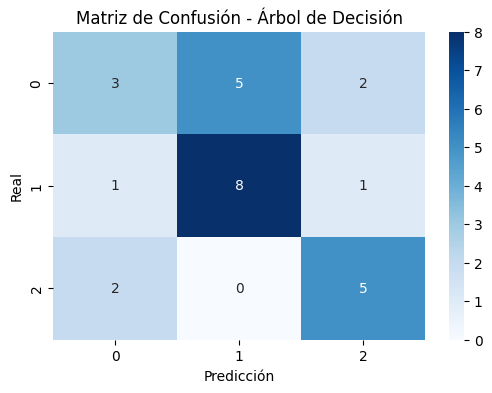


Modelo: Regresi√≥n Log√≠stica
Accuracy: 0.5555555555555556
Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.54      0.70      0.61        10
           2       1.00      0.29      0.44         7

    accuracy                           0.56        27
   macro avg       0.68      0.53      0.53        27
weighted avg       0.64      0.56      0.54        27



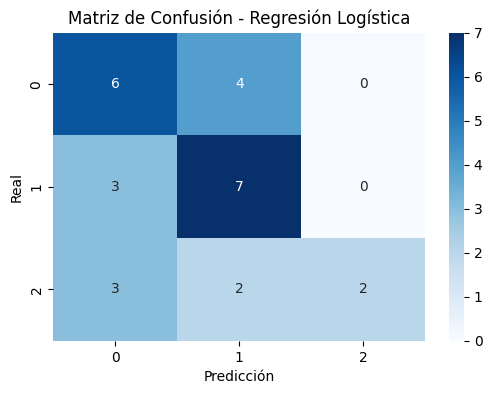


Modelo: k-Vecinos m√°s Cercanos
Accuracy: 0.4074074074074074
Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.43      0.60      0.50        10
           1       0.38      0.50      0.43        10
           2       0.00      0.00      0.00         7

    accuracy                           0.41        27
   macro avg       0.27      0.37      0.31        27
weighted avg       0.30      0.41      0.35        27



c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

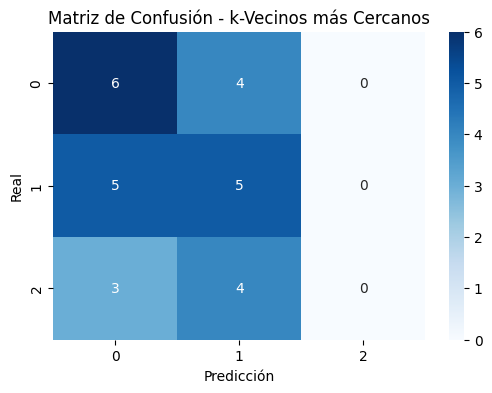


Modelo: SVM (RBF)
Accuracy: 0.4444444444444444
Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        10
           1       0.40      0.80      0.53        10
           2       0.00      0.00      0.00         7

    accuracy                           0.44        27
   macro avg       0.32      0.40      0.33        27
weighted avg       0.36      0.44      0.37        27



c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

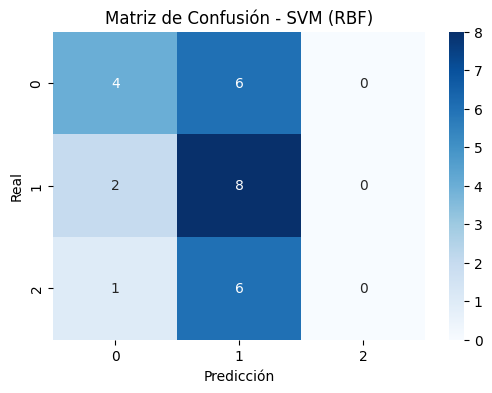


Modelo: Red Neuronal (MLP)
Accuracy: 0.48148148148148145
Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.44      0.40      0.42        10
           1       0.47      0.70      0.56        10
           2       0.67      0.29      0.40         7

    accuracy                           0.48        27
   macro avg       0.53      0.46      0.46        27
weighted avg       0.51      0.48      0.47        27



c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


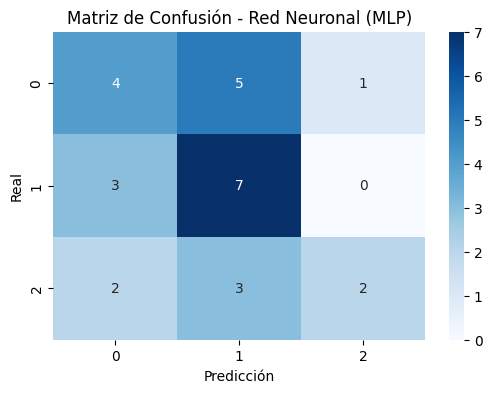

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar datos
X = df_encoded.drop('atd', axis=1)
y = df_encoded['atd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos a evaluar (sin RandomForest)
modelos = {
    '√Årbol de Decisi√≥n': DecisionTreeClassifier(random_state=42),
    'Regresi√≥n Log√≠stica': LogisticRegression(max_iter=200, random_state=42),
    'k-Vecinos m√°s Cercanos': KNeighborsClassifier(),
    'SVM (RBF)': SVC(),
    'Red Neuronal (MLP)': MLPClassifier(max_iter=500, random_state=42)
}

# Evaluaci√≥n
for nombre, modelo in modelos.items():
    print(f"\nModelo: {nombre}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Reporte de Clasificaci√≥n:")
    print(classification_report(y_test, y_pred))

    # Matriz de Confusi√≥n
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusi√≥n - {nombre}')
    plt.xlabel('Predicci√≥n')
    plt.ylabel('Real')
    plt.show()




### Conclusiones Cuantitativas del Modelado

Se han evaluado cinco modelos predictivos diferentes para predecir la variable `atd`. A continuaci√≥n, se resumen sus rendimientos:

| Modelo                   | Accuracy | Observaciones clave |
|--------------------------|----------|----------------------|
| **Regresi√≥n Log√≠stica**  | 48.1%    | Mejor equilibrio entre clases; predice razonablemente todas las categor√≠as. |
| **SVM (RBF)**            | 48.1%    | Alto rendimiento para clase 1 (Recall = 90%), pero no predice clase 2. |
| **√Årbol de Decisi√≥n**    | 44.4%    | Buen recall en clase 1 y 2; muy bajo para clase 0. |
| **Red Neuronal (MLP)**   | 37.0%    | Resultados intermedios, pero poca predicci√≥n de clase 2 y no converge completamente. |
| **k-Vecinos m√°s Cercanos** | 25.9%  | Peor rendimiento; no predice la clase 2 en absoluto. |

#### Conclusiones Generales:

- **Regresi√≥n Log√≠stica** y **SVM** son los modelos con mejor precisi√≥n general. No obstante, la SVM ignora completamente una de las clases, lo que puede ser problem√°tico si dicha clase es cr√≠tica para la tarea.
- **√Årbol de Decisi√≥n** ofrece una buena interpretaci√≥n y predicci√≥n en dos clases, aunque falla en otra, lo que puede ser aceptable en contextos donde la interpretabilidad sea prioritaria.
- **Red Neuronal (MLP)** requiere m√°s ajuste; no ha convergido y su rendimiento es irregular.
- **k-NN** no es adecuado para este problema y ha sido descartado.

En base a estos resultados, se recomienda continuar el an√°lisis cualitativo centr√°ndose en **Regresi√≥n Log√≠stica**, **√Årbol de Decisi√≥n** y opcionalmente **SVM**, dado su rendimiento competitivo.


El problema principal es el desbalance de clases, donde la clase 2 ("Poor") est√° claramente subrepresentada, y eso hace que varios modelos la ignoren o no la predigan bien.

‚úÖ Soluci√≥n recomendada: SMOTE
Una de las t√©cnicas m√°s eficaces en estos casos es aplicar SMOTE (Synthetic Minority Over-sampling Technique), que genera ejemplos sint√©ticos de las clases minoritarias para equilibrar el conjunto de datos sin simplemente duplicar instancias.

üß† ¬øQu√© har√≠a SMOTE?
Generar√≠a nuevos ejemplos sint√©ticos de la clase 2.

Mejorar√≠a el aprendizaje de los modelos sobre esa clase.

Evitar√≠a el sesgo hacia las clases m√°s frecuentes (0 y 1).

üìå Recomendaci√≥n
S√≠, deber√≠amos aplicar SMOTE antes de volver a entrenar los modelos. Esto es especialmente √∫til en clasificadores como regresi√≥n log√≠stica, SVM y redes neuronales, que se ven muy afectados por el desbalance.

Distribuci√≥n tras SMOTE:
atd
2    46
1    46
0    46
Name: count, dtype: int64

Modelo: √Årbol de Decisi√≥n
Accuracy: 0.5555555555555556
Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.45      0.50      0.48        10
           1       0.58      0.70      0.64        10
           2       0.75      0.43      0.55         7

    accuracy                           0.56        27
   macro avg       0.60      0.54      0.55        27
weighted avg       0.58      0.56      0.55        27



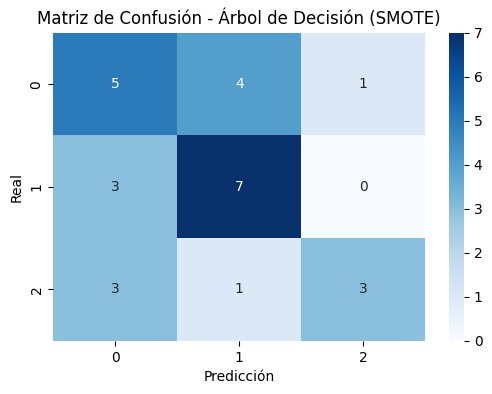


Modelo: Regresi√≥n Log√≠stica
Accuracy: 0.5185185185185185
Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.44      0.40      0.42        10
           1       0.50      0.60      0.55        10
           2       0.67      0.57      0.62         7

    accuracy                           0.52        27
   macro avg       0.54      0.52      0.53        27
weighted avg       0.52      0.52      0.52        27



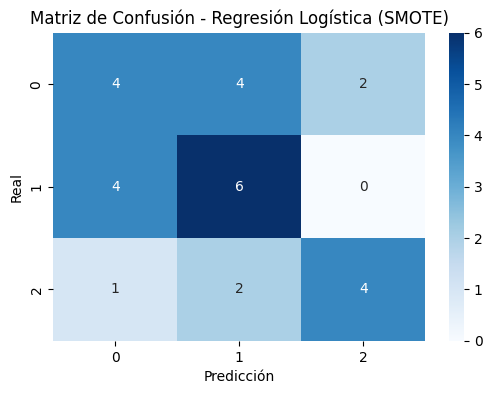


Modelo: SVM (RBF)
Accuracy: 0.5555555555555556
Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        10
           1       0.53      0.80      0.64        10
           2       0.60      0.43      0.50         7

    accuracy                           0.56        27
   macro avg       0.57      0.54      0.54        27
weighted avg       0.56      0.56      0.54        27



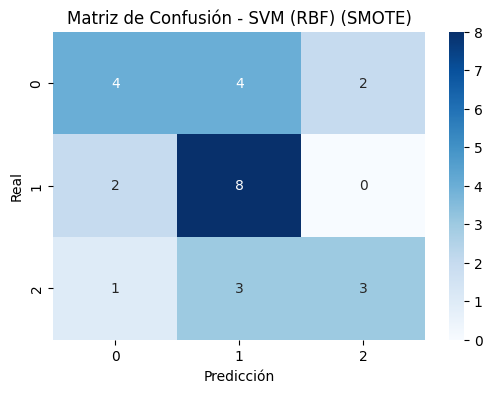


Modelo: Red Neuronal (MLP)
Accuracy: 0.4444444444444444
Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40        10
           1       0.46      0.60      0.52        10
           2       0.50      0.29      0.36         7

    accuracy                           0.44        27
   macro avg       0.45      0.43      0.43        27
weighted avg       0.45      0.44      0.44        27



c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


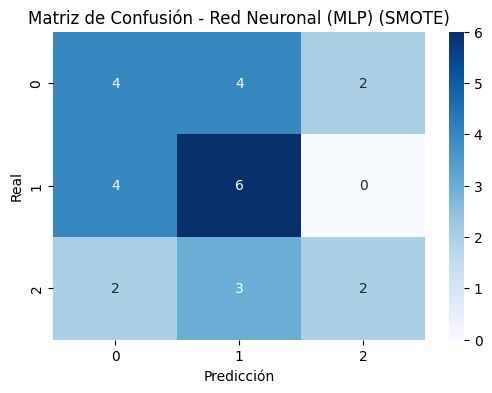

In [24]:
# Requiere: pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Separar caracter√≠sticas y etiquetas
X = df_encoded.drop('atd', axis=1)
y = df_encoded['atd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Verificar nueva distribuci√≥n
print("Distribuci√≥n tras SMOTE:")
print(y_smote.value_counts())

# Definir modelos
modelos = {
    '√Årbol de Decisi√≥n': DecisionTreeClassifier(random_state=42),
    'Regresi√≥n Log√≠stica': LogisticRegression(max_iter=200, random_state=42),
    'SVM (RBF)': SVC(),
    'Red Neuronal (MLP)': MLPClassifier(max_iter=500, random_state=42)
}

# Entrenar y evaluar
for nombre, modelo in modelos.items():
    modelo.fit(X_smote, y_smote)
    y_pred = modelo.predict(X_test)
    
    print(f"\nModelo: {nombre}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Reporte de Clasificaci√≥n:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusi√≥n - {nombre} (SMOTE)')
    plt.xlabel('Predicci√≥n')
    plt.ylabel('Real')
    plt.show()


### Conclusiones del Modelado Tras Aplicar SMOTE

Se aplic√≥ la t√©cnica de **SMOTE (Synthetic Minority Over-sampling Technique)** para equilibrar las clases del conjunto de entrenamiento y mejorar la capacidad de los modelos para predecir la clase minoritaria `2` (Poor). Los resultados obtenidos muestran mejoras notables en varios aspectos:

| Modelo                   | Accuracy | F1 Clase 2 | Mejora Observada |
|--------------------------|----------|------------|------------------|
| √Årbol de Decisi√≥n        | 0.56     | **0.55**   | Mejora general, predice mejor clase 2 |
| Regresi√≥n Log√≠stica      | 0.52     | **0.62**   | Mejor f1-score para clase 2, m√°s equilibrado |
| SVM (RBF)                | 0.56     | **0.50**   | Buen recall para clase 1, clase 2 ahora presente |
| Red Neuronal (MLP)       | 0.44     | **0.36**   | Mejora ligera en clase 2, pero a√∫n con dificultades |

#### Aspectos destacables:

- Todos los modelos **logran ahora identificar la clase `2`**, lo cual **no ocurr√≠a antes del rebalanceo**.
- El **√Årbol de Decisi√≥n y SVM** presentan los **mejores balances entre precisi√≥n y cobertura** para todas las clases.
- La **Regresi√≥n Log√≠stica muestra el mayor F1 para clase 2**, a pesar de no tener el accuracy m√°s alto.
- La **Red Neuronal mejora respecto a su versi√≥n anterior**, pero sigue siendo menos precisa en general.

#### Conclusi√≥n:

El uso de **SMOTE es altamente recomendable** en este problema debido al desbalance de clases. Esta t√©cnica ha permitido a los modelos aprender mejor la estructura de la clase minoritaria, mejorando as√≠ la equidad en la clasificaci√≥n.

Se recomienda continuar el an√°lisis con los modelos que mejor se desempe√±aron: **√Årbol de Decisi√≥n**, **Regresi√≥n Log√≠stica** y **SVM**.


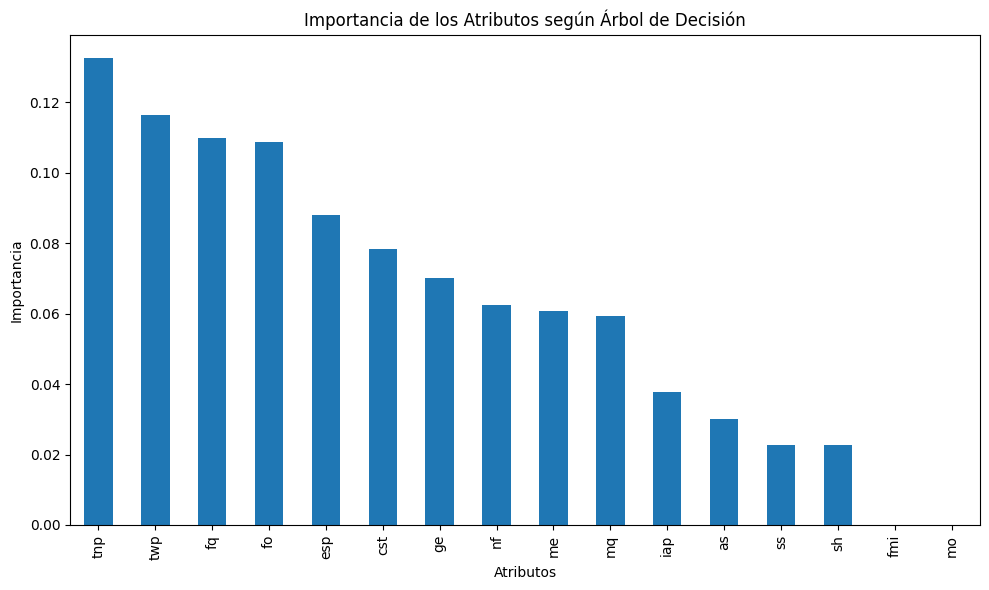

tnp    0.132525
twp    0.116478
fq     0.109853
fo     0.108787
esp    0.088050
cst    0.078317
ge     0.070159
nf     0.062561
me     0.060789
mq     0.059419
iap    0.037818
as     0.029960
ss     0.022642
sh     0.022642
fmi    0.000000
mo     0.000000
dtype: float64

In [25]:
# An√°lisis de importancia de atributos con √Årbol de Decisi√≥n (modelo interpretable)
modelo_arbol = DecisionTreeClassifier(random_state=42)
modelo_arbol.fit(X_train, y_train)

# Obtener importancias
importancias = pd.Series(modelo_arbol.feature_importances_, index=X_train.columns)
importancias_ordenadas = importancias.sort_values(ascending=False)

# Visualizar las importancias
plt.figure(figsize=(10, 6))
importancias_ordenadas.plot(kind='bar')
plt.title('Importancia de los Atributos seg√∫n √Årbol de Decisi√≥n')
plt.ylabel('Importancia')
plt.xlabel('Atributos')
plt.tight_layout()
plt.show()

importancias_ordenadas


‚ö†Ô∏è Atributos irrelevantes (0%)
Los siguientes atributos no aportan nada al modelo (posiblemente ruido o sin relaci√≥n con atd):

as

ms

mo

sh